# Downscaling Temperature at 2m for **Manhattan**

**Variables:**
* Variable to be downscaled: Temperature at 2 meters (T2)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 2,205.41 km²

# Import libraries

In [89]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [64]:
!python --version

Python 3.8.18


# Define paths and retrieve files from server

In [143]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/train/uWRF_final_01-02.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/val/uWRF_final_03.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/test/uWRF_final_03.nc')

nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_val_data.nc')
nam_test = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-NYC-data/aligned_nam_test_data.nc')

# Using different visualization tool and calculating spatial coverage

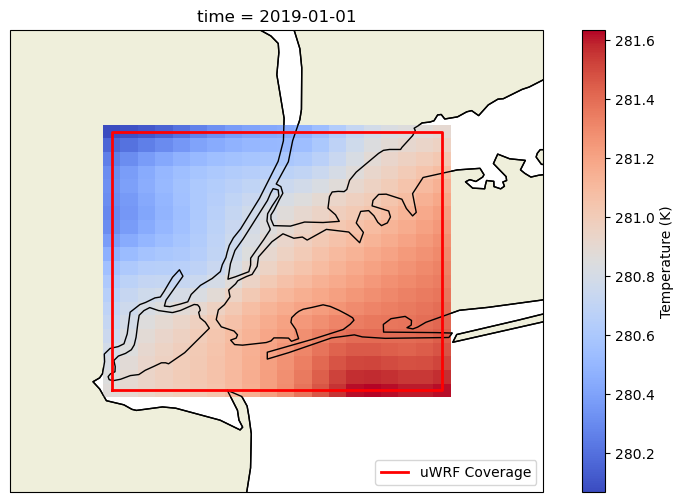

In [144]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-NYC-split/train/uWRF_final_01-02.nc')

# Extract T2 for the first timestep
t2_first = uwrf_train['T2'].isel(time=0)

# Get spatial coverage
uwrf_min_lat = t2_first['latitude'].values.min()
uwrf_max_lat = t2_first['latitude'].values.max()
uwrf_min_lon = t2_first['longitude'].values.min()
uwrf_max_lon = t2_first['longitude'].values.max()

# Plotting with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title("uWRF Dataset Coverage and T2 Field (First Time Step)", fontsize=14)

# Add coastlines and features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS)

# Plot T2 data
t2_first.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'Temperature (K)'})

# Add bounding box
ax.plot(
    [uwrf_min_lon, uwrf_min_lon, uwrf_max_lon, uwrf_max_lon, uwrf_min_lon],
    [uwrf_min_lat, uwrf_max_lat, uwrf_max_lat, uwrf_min_lat, uwrf_min_lat],
    color='red', transform=ccrs.PlateCarree(), linewidth=2, label='uWRF Coverage'
)

# Set extent for the map
ax.set_extent([uwrf_min_lon - 0.2, uwrf_max_lon + 0.2, uwrf_min_lat - 0.2, uwrf_max_lat + 0.2])

# Add legend
ax.legend(loc='lower right')

plt.show()


In [145]:
import numpy as np

uwrf_min_lat = min(uwrf_train['latitude'].values)
uwrf_max_lat = max(uwrf_train['latitude'].values)
uwrf_min_lon = min(uwrf_train['longitude'].values)
uwrf_max_lon = max(uwrf_train['longitude'].values)

nam_min_lat = min(nam_train['latitude'].values)
nam_max_lat = max(nam_train['latitude'].values)
nam_min_lon = min(nam_train['longitude'].values)
nam_max_lon = max(nam_train['longitude'].values)

def calculate_area(min_lat, max_lat, min_lon, max_lon):
    # Earth's radius in km
    R = 6371

    # Convert degrees to radians
    min_lat_rad = np.radians(min_lat)
    max_lat_rad = np.radians(max_lat)
    min_lon_rad = np.radians(min_lon)
    max_lon_rad = np.radians(max_lon)

    # Calculate differences
    delta_lat = max_lat_rad - min_lat_rad
    delta_lon = max_lon_rad - min_lon_rad

    # Area of a spherical rectangle segment
    area = (R**2) * delta_lon * (np.sin(max_lat_rad) - np.sin(min_lat_rad))
    return abs(area)

# uWRF area
uwrf_area = calculate_area(uwrf_min_lat, uwrf_max_lat, uwrf_min_lon, uwrf_max_lon)
print(f"uWRF Area: {uwrf_area:.2f} km²")

# NAM area
nam_area = calculate_area(nam_min_lat, nam_max_lat, nam_min_lon, nam_max_lon)
print(f"NAM Area: {nam_area:.2f} km²")

# Intersection area
intersection_area = calculate_area(
    max(uwrf_min_lat, nam_min_lat),
    min(uwrf_max_lat, nam_max_lat),
    max(uwrf_min_lon, nam_min_lon),
    min(uwrf_max_lon, nam_max_lon),
)
if intersection_area > 0:
    print(f"Intersection Area: {intersection_area:.2f} km²")
else:
    print("No overlap between the datasets.")


uWRF Area: 3106.96 km²
NAM Area: 2205.41 km²
Intersection Area: 2205.41 km²


# Define variables

In [66]:
#High resolution (uWRF) data
T2_hr_train = uwrf_train.T2
T2_hr_val = uwrf_val.T2
T2_hr_test = uwrf_test.T2

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC

#--------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2
T2_lr_val = nam_val.T2
T2_lr_test = nam_test.T2

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Scale the data

In [83]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)


# Compare original resolutions

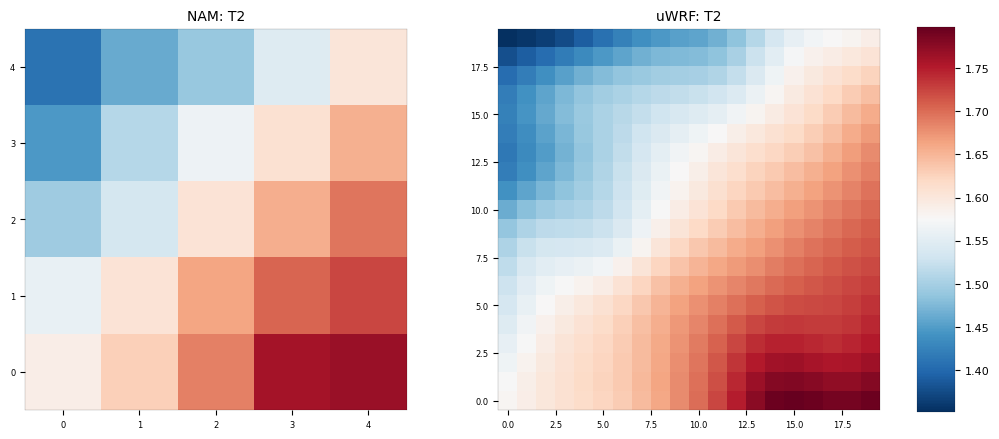

In [110]:
#T2: Temperature at 2 meters
ecv.plot((x_train[0].values, y_train[0]), share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM: T2', 'uWRF: T2'))

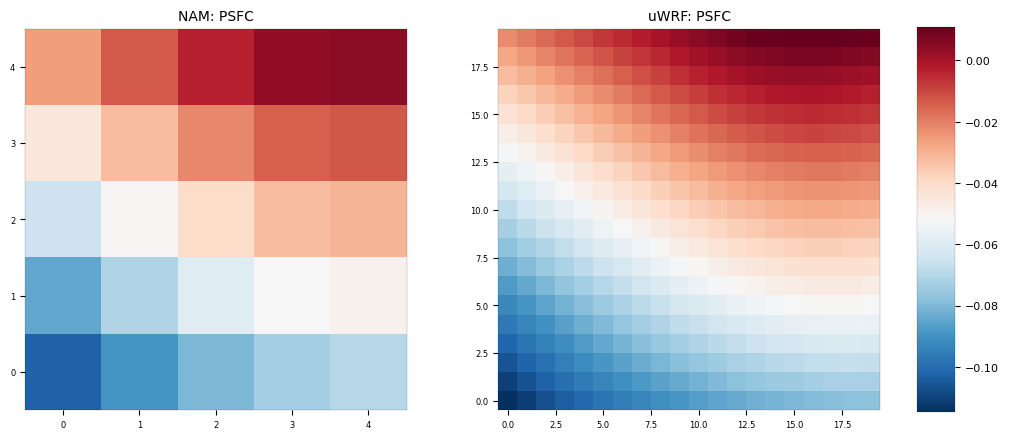

In [109]:
#PSFC: Surface Pressure
ecv.plot((x_z_train[0].values, y_z_train[0]),
         show_coastline=True, share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM: PSFC', 'uWRF: PSFC'))

# Add channel dimension

In [70]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

# Verify shape

In [71]:
print("T2 hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("T2 lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

T2 hr data shape:
(1537, 20, 20, 1) (812, 20, 20, 1) (812, 20, 20, 1)

PSFC hr data shape:
(1537, 20, 20, 1) (812, 20, 20, 1) (812, 20, 20, 1)

T2 lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)

PSFC lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)


# Example coarsening method occuring during training:

For this model, we do not use the LR data (NAM) during training. Instead, we use a coarsened version (via interpolation) of the HR (uWRF) T2 and PSFC data. The DL4DS model carries out this interpolation on the fly by using the helper function dds.create_pair_hr_lr() (not to be called by the user). This process is done **automatically** inside the training loop (by calling one of the two (Supervised vs GAN) Trainer classes in DL4DS), which we examplify here with the spc upsampling. 

HR array: (20, 20, 1), LR array (5, 5, 2)


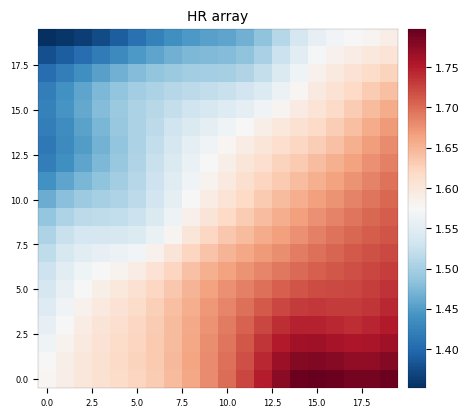

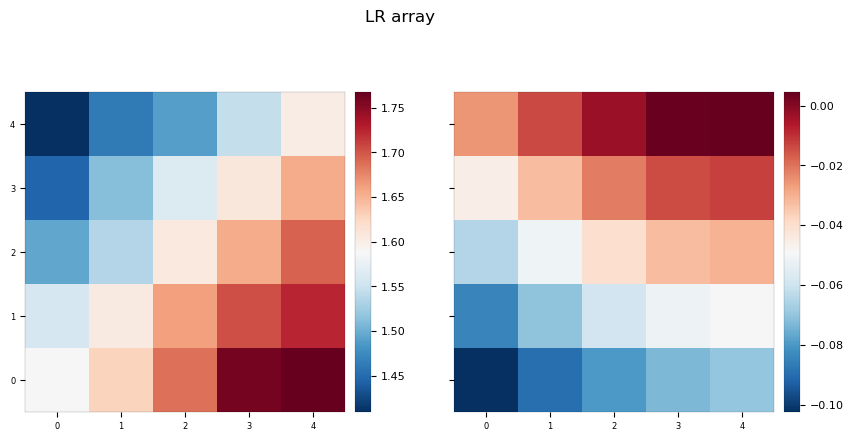

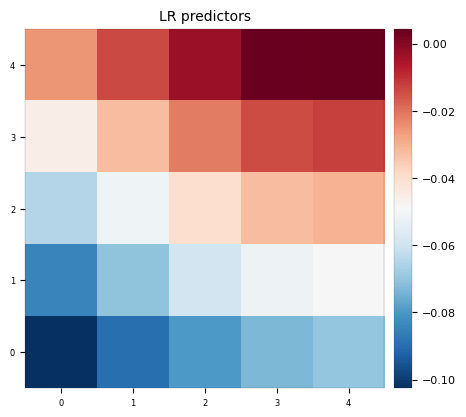

In [72]:
_ = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

# Training Model

Possible backbones:
* resnet: MAE = 0.09434913098812103
* densenet: MAE = 0.04823455959558487 **best**
* convnet: MAE = 0.4711471498012543
* convnext: MAE = doesn't work

In [73]:
ARCH_PARAMS = dict(n_filters=20,
                   n_blocks=4,
                   normalization=None,
                   dropout_rate=0.5,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=False)

trainer = dds.SupervisedTrainer(
    backbone='densenet',
    upsampling='spc', 
    data_train=y_train,
    data_val=y_val,
    data_test=y_test,
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4, 
    time_window=None, 
    static_vars=None,
    predictors_train=[y_z_train],
    predictors_val=[y_z_val],
    predictors_test=[y_z_test],
    interpolation='inter_area',
    patch_size=None, 
    batch_size=60,
    loss='mae',
    epochs=50, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=False, patience=6, min_delta=0, 
    save=False, 
    save_path=None,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)
trainer.run()

List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-01-16 14:45:51
--------------------------------------------------------------------------------
Model: "densenet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_3 (InputLayer)                        [(None, None, None, 2)]                      0              []                                           
                                                                                                                                                      
 conv2d_66 (Conv2D)                          (None

# Inference on uWRF test set

In [74]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=[y_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=60,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-16 14:47:03
--------------------------------------------------------------------------------
14/14 [==============================] - 1s 17ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:00.631710
--------------------------------------------------------------------------------


# Inference on NAM

In [75]:
pred1 = dds.Predictor(
    trainer, 
    x_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=[x_z_train], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-16 14:47:03
--------------------------------------------------------------------------------
385/385 [==============================] - 2s 4ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:01.839198
--------------------------------------------------------------------------------


# Comparing predictions on uWRF test set

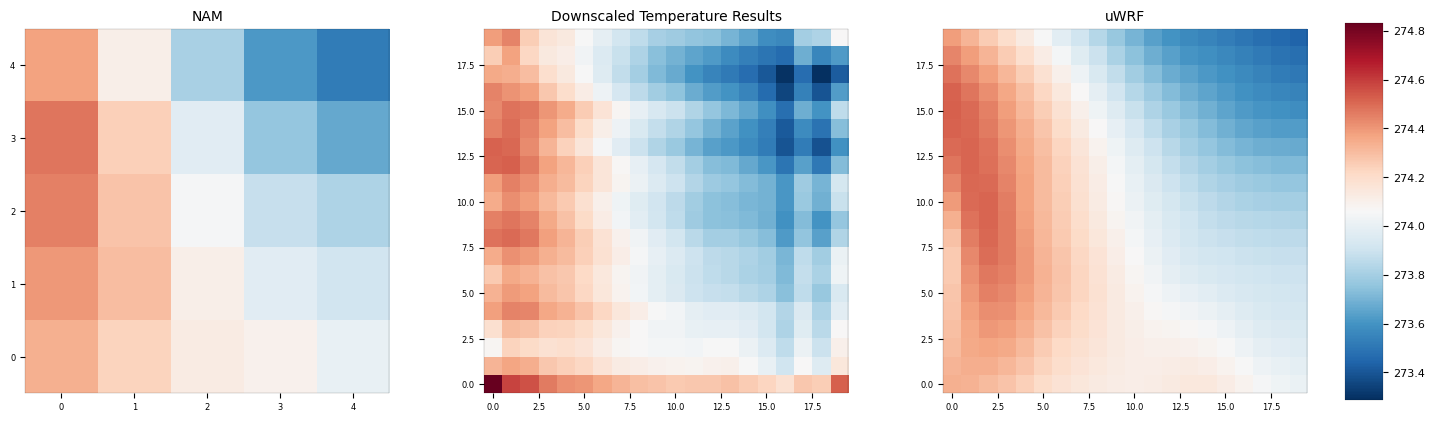

MAE for test set: 0.10857902467250824


In [76]:
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_x_test[0].values, unscaled_y_pred[0], unscaled_y_test[0].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

mae = dds.losses.mae(unscaled_y_test[0].values, unscaled_y_pred[0])
print(f"MAE for test set: {mae}")

# Comparing predictions on NAM data 

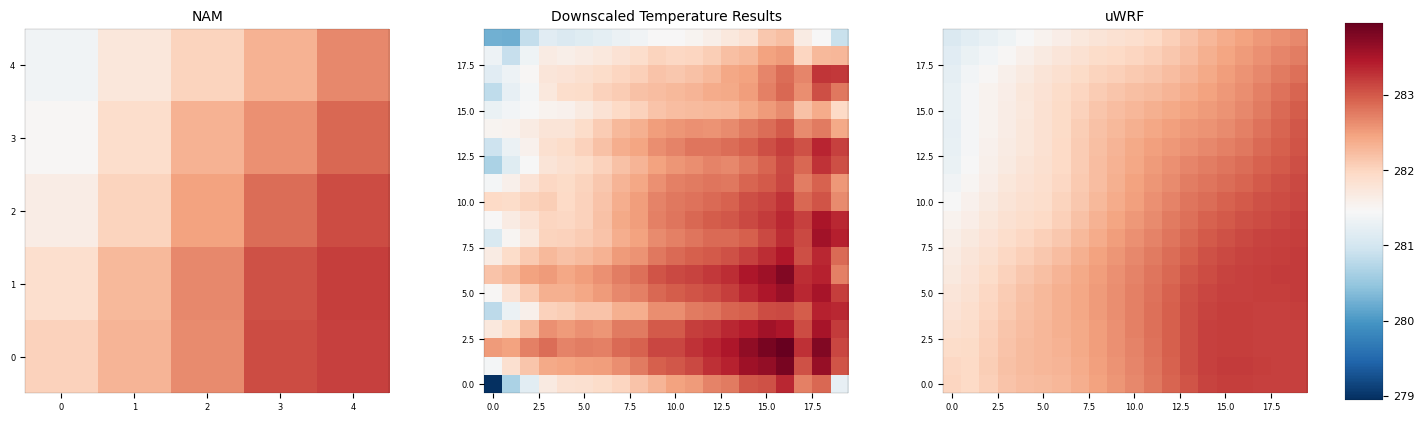

In [94]:
unscaled_y_train = T2_scaler_train.inverse_transform(y_train)
unscaled_x_train = T2_scaler_train.inverse_transform(x_train)
ecv.plot((unscaled_x_train[2].values, unscaled_x_pred[2], unscaled_y_train[2].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

# Loss calculations

In [78]:
mae = dds.losses.mae(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")

MAE for training: 0.10857902467250824
MSE for training: 0.017030935734510422

MAE on NAM: 6.923196315765381
MSE on NAM: 48.314369201660156

MAE loss is not the same
MSE loss is not the same
MAE between predictions, to see if they're exactly the same:
MAE: 6.985823631286621
